<font size='5'>Main task of this notebook</font><br>
- Extract salt cave location 
- Extract salt cave capacity of each location from original map.</font>
<br><br><br>
This Picture shows how to convert original map into a vector map with six different multipolygons
![Architecture 1](structure1.png)

------------------------------------


------------------------------------
This Picture shows how to estimate capacity of each polygon in vector map
![Architecture 2](structure2.png)

In [13]:
import json
import pathlib

import cv2
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import re


from pathlib import Path
from osgeo import gdal, osr, ogr

import geopandas
import fiona
import rasterio
import rasterio.features
from shapely.geometry import shape, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point
import mapclassify
import geoplot.crs as gcrs

from tqdm import tqdm
import geoplot
import pycountry
from shapely.geometry import LineString

# Load Important GCPs
 - gcps is the projection of the original raster
 - It is manually created with help of QGIS and OSM map
 - It is saved as 'original/GCP_Points.json'
 
 This is GIS interface
 Just manually choose two point, QGIS automatically calculate coordinate of two points

![gcp](how_to_generate_gcps.png)

In [2]:
with open('original/GCP_Points.json') as jsonfile:
    gcp=json.load(jsonfile)

object_gcp=[]
for unit in gcp:
    object_gcp.append(gdal.GCP(unit[2],unit[3],0,unit[0],unit[1]))



# Layer splitting 

## prepare data

In [3]:
img = cv2.imread('original/salt_cave.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# read in file is BGR not RGB

# flat picture to list and create pandas dataframe
img_list = img.reshape((-1, 3))
img_df = pd.DataFrame(img_list)

# definition of two key functions

In [4]:
def extract_with_threshold(threshold=10, i=None,
                           color=[[97, 78, 168], [58, 197, 163], [226, 247, 139], [
                               255, 224, 122], [255, 100, 50], [177, 0, 67]],
                           mask=img_df, save_mode=False):
    '''
    extract capacity layer based on given color 

    Parameter
    ----------
    threshold : float, default = 10
        threshold is variable use to juge a pixel in original raster
        whether it is background pixel or not
        The way of judgment is to calculate the veriance of a pixel's 
        three color channels. Based on observations, background pixel 
        in RGB color space always have a very low veriance (like black
        [0,0,0], white [255,255,255], grey [160,162,160]...) 
        this function will treat the pixel with variance<threshold as 
        background pixel

    i : int, default = None
        i is index of your target color in the color list. It controls 
        the mode of this function. 
        Mode 1 : i == None
        This function will extract all capacity layers; 
        assgin the pixels in each layer with the representative color of the layer.
        Mode 2 : i == int
        This function will extract a layer of specific color in color list color[i]
        assgin the pixels in the layer with the representative color of the layer

    color : list, default = [[97,78,168],[58,197,163],[226,247,139],[255,224,122],[255,100,50],[177,0,67]]
        RGB color list of the capacity legend in original raster.

    mask : pd.DataFrame
        This is the original raster we are going to extract capacity layers from  

    save_mode: Boole, default = False
        If this parameter set True, it will change output image to a image, 
        that just have two type pixel {[0,0,0], [255,255,255]}
        
    Return
    ------------
    three channels (RGB) image array (np.array)
    '''

    # create clustering object, the color are the center
    cluster = KMeans(6)
    cluster.cluster_centers_ = np.array(color, dtype='float64')

    # copy the data
    data = mask.copy()

    # before matching all pixel have same label 255
    data['predict'] = 255

    # match each pixel to a specific color, ignore background pixels
    data.loc[mask[mask.var(axis=1) > threshold].index, 'predict'] = cluster.predict(
        mask[mask.var(axis=1) > threshold])

    # uniform color in each layer
    if i == None:
        # make other pixel to white
        data.loc[data[data.predict == 255].index, :] = [255, 255, 255, 255]
    else:
        data.loc[data[data.predict != i].index, :] = [255, 255, 255, 255]
        # pixel without capacity data (Background) is white
        if not save_mode:
            data.loc[data[data.predict == i].index, :] = color[i]+[i]
        else:
            data.loc[data[data.predict == i].index, :] = [0, 0, 0, 0]
            # pixel with capacity data is black
    return data.iloc[:, :-1].values.astype('int').reshape(1800, 2880, 3)

Why RGB color sapce is better than HLS during extracting capacity layer based on colors in capacity legend in original map?
- RGB Space
   - in RGB space is <font color='green'>simpler</font> to filter all background pixel <font color='green'>at once</font>: just based on variance of three color channels
   - in RGB space capacity pixels will be <font color='green'>correctly</font> assgin to the cluster</font> based on predefined color (using Kmeans++ clustering)

- HLS Sapce
   - it is <font color='red'>complicated to filter different background pixels</font>: 
       - use L channel to filter black (L<user defined black threshold) and white (L>user defined white threshold) background pixels
       - use S channel to filter grey (S<user defined grey threshold)
   - it is <font color='red'>problematic during clustering</font> (using Kmeans++ clustering)
       - always miss cluster 300 kwh/m3 pixels(light green pixels) to 250 kwh/m3 pixels (dark green)
       - always miss cluster 400 kwh/m3 pixels to 450 kwh/m3

In [5]:
# save the grey layer to a specific path
def save_img(path, img):
    '''
    Parameters
    ----------
    path : str
        should be relative path
    img : np.array 
        should be three channels RGB image array
    '''
    img_save = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    cv2.imwrite(path, img_save)
    return 1

# QGIS in script

## georeferencer (png to Geotiff)

In [6]:
def warp_with_gcps(input_path, output_path, gcps, gcp_epsg=4326, output_epsg=4326):
    '''
    This function is a tool for generating world files for rasters. 
    It allows you to reference rasters to geographic or projected 
    coordinate systems by creating a new GeoTiff with help of ground control points

    This function consits of two parts
    ----------------------------------
        part 1 is adapted from https://svn.osgeo.org/gdal/trunk/autotest/alg/warp.py

        But part 1 is not perfect. After it save the raster with coordinate system to a
        new GeoTiff. It will some how reduce the resolution of the original raster.
        Therefore There are no longer just two pixel value in new raster. {0,255}.
        This will cause a big problem in next step vectorization.

        So part 2 try to solve the problem caused by part 1.
        part 2 will let the pixel values of raster return to the state of just two value {0,255}
        The pixel with pixel value>20 will set it pixel value to 255. Other pixels' value will
        be 0.

    Parameters
    -----------
    input_path : str 
        it should be relative path
        input image is .png file

    output_path : str
        it should be relative path
        output raster is .tif file (driver: GTiff)

    gcps: list
        it is a list of gdal.GCP objects (ground control points).
        It is manually created with QGIS and store in a json file :
        'original/GCP_Points.json'

    gcp_epsg: int, default = 4326
        it is the coordinate reference system of ground control points.
        4326 means crs = EPSG:4326 (latitude, longtitude)

    output_epsg: int, default = 4326
        it is the coordinate reference system of output raster. 
        4326 means crs = EPSG:4326 (latitude, longtitude) 
    
    Return
    ------------
    no return
    the result of these function will store in output_path

    '''
    # -----------------------part 1----------------------------------
    # Open the source dataset and add ground control points to it
    src_ds = gdal.OpenShared(str(input_path), gdal.GA_ReadOnly)
    gcp_srs = osr.SpatialReference()
    gcp_srs.ImportFromEPSG(gcp_epsg)
    gcp_crs_wkt = gcp_srs.ExportToWkt()
    src_ds.SetGCPs(gcps, gcp_crs_wkt)

    # Define target spatial reference system
    dst_srs = osr.SpatialReference()
    dst_srs.ImportFromEPSG(output_epsg)
    dst_wkt = dst_srs.ExportToWkt()

    error_threshold = 0  # error threshold --> use same value as in gdalwarp
    resampling = gdal.GRA_Bilinear

    # Call AutoCreateWarpedVRT() to fetch default values for target raster dimensions and geotransform
    tmp_ds = gdal.AutoCreateWarpedVRT(src_ds,
                                      None,  # src_wkt : left to default value --> will use the one from source
                                      dst_wkt,
                                      resampling,
                                      error_threshold)
    dst_xsize = tmp_ds.RasterXSize
    dst_ysize = tmp_ds.RasterYSize
    dst_gt = tmp_ds.GetGeoTransform()
    tmp_ds = None

    # Now create the true target dataset
    dst_path = str(Path(output_path).with_suffix(".tif"))
    dst_ds = gdal.GetDriverByName('GTiff').Create(
        dst_path, dst_xsize, dst_ysize, src_ds.RasterCount)
    dst_ds.SetProjection(dst_wkt)
    dst_ds.SetGeoTransform(dst_gt)
    dst_ds.GetRasterBand(1).SetNoDataValue(255)

    # And run the reprojection
    gdal.ReprojectImage(src_ds,
                        dst_ds,
                        None,  # src_wkt : left to default value --> will use the one from source
                        None,  # dst_wkt : left to default value --> will use the one from destination
                        resampling,
                        0,  # WarpMemoryLimit : left to default value
                        error_threshold,
                        None,  # Progress callback : could be left to None or unspecified for silent progress
                        None)  # Progress callback user data
    dst_ds = None
    # -----------------------------------------------------------------

    # ----------------------part 2-------------------------------------
    with rasterio.open(output_path) as dataset:
        # get dirver of this raster type
        kwds = dataset.profile
        # reduce the band values into 0 and 255
        band = (dataset.read(1) > 20)*255

    with rasterio.open(output_path, 'w', **kwds) as dataset:
        dataset.write_band(1, band.astype('uint8'))
    # -----------------------------------------------------------------

## raster to shapefile

In [7]:
def raster2shp(input_path, output_path, capacity, background=255):
    '''
    This is the function convert raster to shapefile.
    This function will convert the original raster to two multipolygons.
    because our raster only have two type pixel values, 
    so the result of this function are just two multipolygons:
    one is background (value: 0);
    another is salt cave location(value: capacity of the salt cave)

    Parameters
    ----------

    input_path : str 
        It should be relative path.
        It is the path to input raster (GTiff file)
        

    output_path : str
        It should be relative path
        It is the path to store output shapefile (.shp file)

    capacity: int
        denstiy (unit : kwh/m-3 ) of the color in original raster legend. 
        e.g.,200, 300,...

    background: int, default = 255
        This is the value of background pixel in the function warp_with_gcps()

    
    Return
    -----------
    no return 
    output store in output_path
    '''
    with rasterio.open(input_path) as src:
        # metadata for shapefile coordinate reference system
        crs = src.crs
        # read raster as a numpy array
        src_band = src.read(1)
        # Keep track of unique pixel values in the input band
        unique_values = np.unique(src_band)
        # Polygonize with Rasterio. `shapes()` returns an iterable
        # of (geom, value) as tuples
        shapes = list(rasterio.features.shapes(
            src_band, transform=src.transform))

    # metadata for shapefile
    shp_schema = {
        'geometry': 'MultiPolygon',
        'properties': {'val_kwhm3': 'int'}
    }

    # Get a list of all polygons for a given pixel value
    # and create a MultiPolygon geometry with shapely.
    # Then write the record to an output shapefile with fiona.
    # We make use of the `shape()` and `mapping()` functions from
    # shapely to translate between the GeoJSON-like dict format
    # and the shapely geometry type.
    with fiona.open(output_path, 'w', 'ESRI Shapefile', shp_schema, crs) as shp:
        for pixel_value in unique_values:
            # combine the Geometries with same value in last step to multipolygon
            polygons = [shape(geom) for geom, value in shapes
                        if value == pixel_value]
            multipolygon = MultiPolygon(polygons)

            # redefine the value of each multipolygon
            # background multipolygon's value = 0
            # salt cave multipolygon's value = capacity denstiy of the salt cave
            if pixel_value == background:
                pixel_value = 0
            else:
                pixel_value = capacity

            # output shapefile
            shp.write({
                'geometry': mapping(multipolygon),
                'properties': {'val_kwhm3': int(pixel_value)}
            })

# Convert original raster to vector 
this block call all the function above to finish the task, that convert original raster map to vector map

In [8]:
# original raster
png_path = 'raster/capacity_{}.png'
# folder path to store intermediate result. each capcity value have a distinct raster
tif_path = 'raster/capacity_{}.tif'
# folder to store shapefile for each capacity
shp_path = 'vector/capacity_{}.shp'

background = 255
capacity_list = [200, 250, 300, 350, 400, 450]
for i in tqdm(range(len(capacity_list))):
    capacity = capacity_list[i]


# Step1: split original raster into six raster by different colors
    save_img(png_path.format(capacity),
             extract_with_threshold(50, i=i, save_mode=True).astype('uint8'))


# Step2: add gcp to each raster and create new raster with georeference
    warp_with_gcps(png_path.format(capacity),
                   tif_path.format(capacity),
                   object_gcp,
                   gcp_epsg=4326,
                   output_epsg=4326)


# Step3: polygonize rasters in last step
    raster2shp(tif_path.format(capacity),
               shp_path.format(capacity),
               capacity, background)

# Step4: create an aggreated shapefile which have six multipolygons with different capacity
gdflist = []
for capacity in capacity_list:
    gdflist.append(geopandas.read_file(shp_path.format(capacity)))
geodataframe = pd.concat(gdflist)
geodataframe = geodataframe[geodataframe['val_kwhm3'] != 0]
geodataframe = geopandas.GeoDataFrame(
    geodataframe, crs="EPSG:4326").reset_index(drop=True)
geodataframe

# fix invalid polygons
geodataframe['geometry'] = geodataframe.geometry.buffer(0)

# save final.shp in folder vector
geodataframe.to_file('result/final.shp')

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


In [9]:
gdflist[1]

val_kwhm3                                           geometry
0        250  MULTIPOLYGON (((9.60198 57.14199, 9.62489 57.1...
1          0  POLYGON ((-39.33110 63.57935, 50.92936 63.5793...

# View final data

In [5]:
# load capacity map
geodataframe = geopandas.read_file('result/final.shp')
geodataframe['geometry'] = geodataframe.geometry.buffer(0)

# load country shapes map
eu = geopandas.read_file('eu_shapes/country_shapes.geojson')
costa=geopandas.read_file('eu_shapes/offshore_shapes.geojson')

# create sub capacity map of germany
eu[eu['name'] == 'DE']
de=geopandas.GeoDataFrame(pd.concat([eu[eu['name'] == 'DE'],costa[costa['name']=='DE']],ignore_index=True))
geodataframe_de = geopandas.clip(geodataframe, de)
geodataframe_de

val_kwhm3                                           geometry
0        200  MULTIPOLYGON (((14.61900 51.94170, 14.64191 51...
1        250  MULTIPOLYGON (((14.75719 52.07916, 14.75645 52...
2        300  MULTIPOLYGON (((13.97755 52.30824, 13.97755 52...
3        350  MULTIPOLYGON (((14.36700 51.78134, 14.38991 51...
4        400  MULTIPOLYGON (((8.43364 54.04931, 8.43364 54.0...
5        450  MULTIPOLYGON (((14.61900 51.91880, 14.68812 51...

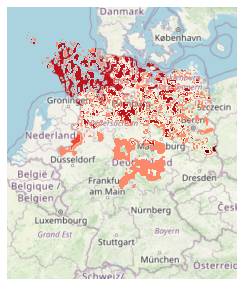

In [6]:
# plot capacity distribution germany onshore
value = geodataframe['val_kwhm3']
scheme = mapclassify.Quantiles(value, k=6)

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
ax = geoplot.webmap(eu, projection=gcrs.WebMercator(),
                    figsize=(5, 5), alpha=0.5)


geoplot.choropleth(
    geodataframe_de, hue=value, scheme=scheme, cmap='Reds',
    legend=False, edgecolor='white', linewidth=0.001, ax=ax
)
plt.show()

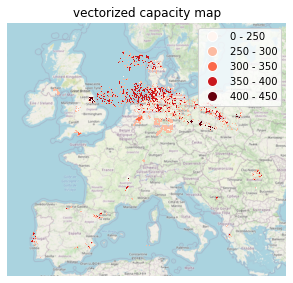

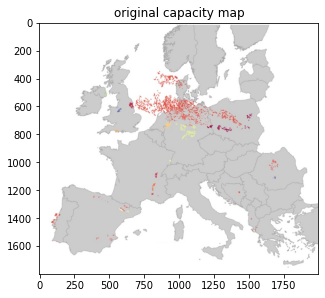

In [12]:
# plot capacity entire EU and compare with original raster
value = geodataframe['val_kwhm3']
scheme = mapclassify.Quantiles(value, k=5)

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
ax = geoplot.webmap(eu, projection=gcrs.WebMercator(),
                    figsize=(5, 5), alpha=0.5)


geoplot.choropleth(
    geodataframe, hue=value, scheme=scheme, cmap='Reds',
    legend=True, edgecolor='white', linewidth=0.001, ax=ax
)
plt.title("vectorized capacity map")
plt.show()

# original map
img = cv2.imread('original/salt_cave.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ff = plt.figure(figsize=(5, 5))
plt.imshow(img[:, 500:2500, :])
plt.title("original capacity map")
plt.show()

# sum to country level

In [6]:
def sum2country(capacity_gdf, eu_shape='eu_shapes/country_shapes.geojson',
                eu_costa='eu_shapes/offshore_shapes.geojson',
                capacity_name='val_kwhm3', save_path='sum2country.geojson'):
    '''
    calculate onshore/offshore capacity/depth in each country 
    for each country:
        onshore : capacity/depth = capacity/volume * area onshore
        offshore : capacity/depth = capacity/volume * area offshore

    Parameters
    -----------

    capacity_gdf : geopandas.GeoDataFrame
        Here should input with the vectorized capacity map

    eu_shape : str, default = 'eu_shapes/country_shapes.geojson'
        It is the shapefile of each EU countries onshore

    eu_costa : str, default =  eu_shapes/offshore_shapes.geojson'
        It is the shapefile of each EU countries offshore

    capacity_name : str, default = 'val_kwhm3'
        It is the column name in capacity_gdf, which store salt cave capacity

    save_path str, default = 'sum2country.geojson'

    Return
    ------------
    eu : geopandas.GeoDataFrame
        the result with capacity/depth
        unit: kwh/m per country
    '''

    # load data
    eu = geopandas.read_file(eu_shape)
    costa = geopandas.read_file(eu_costa)
    eu['onshore'] = 0
    eu['offshore'] = 0
    onshore_capacity = []
    offshore_capacity = []

    for country in eu.name:
        # calculate onshore capacity
        mask_country = eu[eu.name == country]
        part_map = geopandas.clip(capacity_gdf, mask_country)
        area_square_meter = part_map.to_crs(crs='EPSG:3395').area.values
        # add to list onshore capacity
        onshore_capacity.append(
            sum(part_map[capacity_name].values*area_square_meter))

        # calculate offshore capacity
        if sum(costa.name == country) > 0:
            mask_costa = costa[costa.name == country]
            part_map = geopandas.clip(capacity_gdf, mask_costa)
            area_square_meter = part_map.to_crs(crs='EPSG:3395').area.values
            # add to list offshore capacity
            offshore_capacity.append(
                sum(part_map[capacity_name].values*area_square_meter))
        else:
            # if there isn't costa, set offshore capacity=0,
            # add to list off shore capacity
            offshore_capacity.append(0)

    # update country_shapes map with on/offshore capacity
    eu['onshore'] = onshore_capacity
    eu['offshore'] = offshore_capacity
    eu['sum'] = eu['onshore']+eu['offshore']
    eu['full_name'] = eu.name.apply(
        lambda x: pycountry.countries.get(alpha_2=x).name)

    # save file
    eu.to_file(save_path, driver='GeoJSON')
    return eu


eu_capacity = sum2country(geodataframe)
eu_capacity.head()

name                                           geometry       onshore  \
0   AL  POLYGON ((19.74777 42.57890, 19.73433 42.52438...  2.199289e+11   
1   AT  POLYGON ((15.16179 48.93722, 15.24323 48.95293...  0.000000e+00   
2   BE  POLYGON ((4.81545 51.43107, 4.82268 51.41368, ...  0.000000e+00   
3   BG  POLYGON ((22.91956 43.83422, 23.13185 43.84794...  0.000000e+00   
4   BA  POLYGON ((16.94153 45.24122, 16.96799 45.23729...  4.459081e+11   

       offshore           sum               full_name  
0  1.112691e+10  2.310558e+11                 Albania  
1  0.000000e+00  0.000000e+00                 Austria  
2  0.000000e+00  0.000000e+00                 Belgium  
3  0.000000e+00  0.000000e+00                Bulgaria  
4  0.000000e+00  4.459081e+11  Bosnia and Herzegovina

# extract information in Figure 7 by hand
- Uncertainty of the measurements 5 unit length
- Absolute length is not important, only proportional relationship between x-axis and rectangulars is important 

In [47]:
# Measurement record


# The value in the list is onshore50km, onshore, offshore
measurement = {'Albania': [0, 35.478, 0],
               'Greece': [127.917, 0, 25.583],
               'France': [0, 312.904, 0],
               'Bosnia': [0, 368.012, 0],
               'Romania': [0, 403.430, 0],
               'Spain': [249.930, 171.223, 0],
               'Portugal': [273.552, 0, 261.738],
               'Poland': [131.867, 495.928],
               'Norway': [0, 0, 635.651],
               'Denmark': [340.456, 0, 295.193],
               'United Kingdom': [413.274, 0, 245.994],
               'Netherlands': [147.596, 137.757, 389.659],
               'Germany': [568.738, 88.558, 163.340]}

base_point = 112.173
unit_length = 276


# From measurements to real H2 storage capacity
def measure2value(value_list, base_points=276*2-112.173, unit=276):
    if value_list[0]!=0:
        part1 = 10**((base_points+value_list[0])/unit)
    else: 
        part1=0
    if value_list[0]+value_list[1]!=0:
        part2 = 10**((base_points+value_list[0]+value_list[1])/unit)
    else:
        part2=0
    part3 = 10**((base_points+sum(value_list))/unit)

    onshore50 = part1
    onshore = part2-part1
    offshore = part3-part2

    return (onshore50, onshore, offshore, part3)


# create dataframe
# I guess total_onshore= onshore50+onshore
# capacity unit: twh
capacity = {'full_name': [], 'onshore50': [], 'onshore': [],
            'total_onshore': [], 'total_offshore': [], 'total': []}
eu=gpd.read_file('eu_shapes/country_shapes.geojson')
eu['full_name']=eu.name.apply(
        lambda x: pycountry.countries.get(alpha_2=x).name)
for key in measurement.keys():
    for fullname in eu.full_name:
        if not re.match(key.lower(), fullname.lower()):
            continue
        temp = measure2value(measurement[key])
        capacity['full_name'].append(fullname)
        capacity['onshore50'].append(temp[0])
        capacity['onshore'].append(temp[1])
        capacity['total_offshore'].append(temp[2])
        capacity['total'].append(temp[3])
        capacity['total_onshore'].append(temp[0]+temp[1])

# unit of this dataframe is twh
graph_capacity = pd.DataFrame(capacity)
graph_capacity['name']=graph_capacity.full_name.apply(
        lambda x: pycountry.countries.get(name=x).alpha_2)
print('total storage potential allover EU:')
print('real total=84.8 pwh\t', 'measurement total={} pwh'.format(
    round(graph_capacity.total.sum()/10**3, 1)))


# Convert twh to kwh
graph_capacity.drop('full_name',axis=1,inplace=True)
graph_capacity = graph_capacity.set_index('name')
graph_capacity = graph_capacity*1e9
graph_capacity = graph_capacity.reset_index()

print('\n\n')
print('unit: kwh')
# save
graph_capacity.columns=['name','nearshore','onshore','total_onshore','total_offshore','total_kwh']
graph_capacity.to_csv('result/storage_potential_eu_kwh.csv')
graph_capacity.head()

total storage potential allover EU:
real total=84.8 pwh	 measurement total=88.0 pwh



unit: kwh


name     nearshore       onshore  total_onshore  total_offshore  \
0   AL  0.000000e+00  5.273750e+10   5.273750e+10    0.000000e+00   
1   GR  1.140364e+11  0.000000e+00   1.140364e+11    2.713136e+10   
2   FR  0.000000e+00  5.336865e+11   5.336865e+11    0.000000e+00   
3   BA  0.000000e+00  8.451872e+11   8.451872e+11    0.000000e+00   
4   RO  0.000000e+00  1.135740e+12   1.135740e+12    0.000000e+00   

      total_kwh  
0  5.273750e+10  
1  1.411678e+11  
2  5.336865e+11  
3  8.451872e+11  
4  1.135740e+12

# Calculate depth per country (distinguish onshore and offshore) 

In [8]:
# kwh/m
eu_capacity_nozero = eu_capacity[eu_capacity['sum']
                                 > 1e11].reset_index(drop=True)

eu_capacity_nozero = eu_capacity_nozero.merge(
    graph_capacity[['total_onshore', 'total_offshore', 'total', 'full_name']],
    left_on='full_name', right_on='full_name')
eu_capacity_nozero['depth_onshore'] = eu_capacity_nozero['total_onshore'] / \
    eu_capacity_nozero['onshore']
eu_capacity_nozero['depth_offshore'] = eu_capacity_nozero['total_offshore'] / \
    eu_capacity_nozero['offshore']
eu_capacity_nozero['depth_average'] = eu_capacity_nozero['total'] / \
    eu_capacity_nozero['sum']

# replace infinity with 0 (inf is because capacity map from raster doesn't have capacity)
# eu_capacity_nozero.loc[9,'depth_onshore']=eu_capacity_nozero.loc[9,'depth_average']
eu_capacity_nozero.loc[9,
                       'depth_onshore'] = eu_capacity_nozero.loc[9, 'depth_average'] = 0
# replace nan with 0 (nan because both of them is 0)
eu_capacity_nozero.depth_offshore.fillna(0, inplace=True)

# create depth dataframe
eu_depth = eu_capacity_nozero[[
    'full_name', 'depth_average', 'depth_onshore', 'depth_offshore']]

# eu_depth.plot.kde()

eu_depth

full_name  depth_average  depth_onshore  depth_offshore
0                  Albania       0.228246       0.239793        0.000000
1   Bosnia and Herzegovina       1.895429       1.895429        0.000000
2                  Germany       0.498683       0.181823        1.245270
3                  Denmark       0.731116       0.164915        1.074819
4                    Spain       0.333667       0.336349        0.000000
5                   France       0.169349       0.169349        0.000000
6           United Kingdom       0.668388       0.233941        0.920248
7                   Greece       0.269306       0.279953        0.232191
8              Netherlands       0.787626       0.113479        1.035583
9                   Norway       0.000000       0.000000        0.981879
10                  Poland       0.336014       0.336167        0.000000
11                Portugal       1.453929       0.321697        2.627954
12                 Romania       0.351680       0.351680        0.000000

In [2]:
import geopandas as gpd

In [158]:
density_map=gpd.read_file('new_energy_capacity_map_kwhm2.geojson')
density_map.geometry=density_map.geometry.buffer(0)

In [101]:
import geopandas as gpd
import pandas as pd

# snakemake is a global value snakemake.input.

onshore_path='resources/country_shapes.geojson'
offshore_path='resources/offshore_shapes.geojson'

density_map_path='result/final.shp'
capacity_path='result/storage_potential_eu_kwh.csv'

def geo_concat(list_to_concat):
    return gpd.GeoDataFrame(pd.concat(list_to_concat,ignore_index=True)).set_crs('EPSG:4326')

def create_nearshore_50_pair(on_path,off_path):
    onshore=gpd.read_file(on_path)
    offshore=gpd.read_file(off_path)
    offshore_buffer=offshore.to_crs(crs='EPSG:3395')
    offshore_buffer.geometry=offshore_buffer.buffer(50000) #50km buffer
    offshore_buffer=offshore_buffer.to_crs(crs='EPSG:4326')
    nearshore=gpd.clip(onshore,offshore_buffer)
    realonshore=gpd.overlay(onshore,offshore_buffer,how='difference')
    return nearshore, realonshore

def calculate_depth(mask,depth_type,capacity_path,density_map,capacity_name='val_kwhm3'):
    capacity=pd.read_csv(capacity_path)
    density_map= gpd.read_file(density_map)
    density_map.geometry=density_map.geometry.buffer(0)
    
    capacity_per_depth = []
    #calculate capacity_per_depth
    #clip denstiy_map with mask
        

    for country in mask.name:
        # calculate onshore capacity
        mask_country = mask[mask.name == country]
        part_map = gpd.clip(density_map, mask_country)
        area_square_meter = part_map.to_crs(crs='EPSG:3395').area.values
        # add to list onshore capacity
        capacity_per_depth.append(
            sum(part_map[capacity_name].values*area_square_meter))
    mask['capacity_per_depth']=capacity_per_depth
    df_capacity_per_depth=mask[['name','capacity_per_depth']]
    
    capacity=capacity.merge(df_capacity_per_depth,left_on='name',right_on='name',how='left')
    
    capacity[depth_type+'_depth']=capacity[depth_type]/capacity['capacity_per_depth']
    
    return capacity[['name',depth_type+'_depth']]



def get_capacity(capacity,density_map,mask_list,depth_list,capacity_name='val_kwhm3'):
    capacity_per_country= []
    for mask,depth,storage_type in zip(mask_list,depth_list,['onshore','nearshore','offshore']):
        depth=clean_dataframe(depth)
        for country in depth.name:
            # calculate onshore capacity
            mask_country = mask[mask.name == country]
            part_map = gpd.clip(density_map, mask_country)
            #calculate capacity per country
            part_map['capacity'] = part_map.to_crs(crs='EPSG:3395').area*depth[depth.name==country].iloc[0,-1]\
            *part_map[capacity_name]
            part_map['storage_type']= storage_type
            # add to list onshore capacity
            capacity_per_country.append(part_map)
    return geo_concat(capacity_per_country)

        

def calculate_capacity_shape(onshore,nearshore,realoffshore,density_map_path,capacity_path,capacity_name='val_kwhm3'):
    capacity=pd.read_csv(capacity_path)
    density_map= gpd.read_file(density_map_path)
    density_map.geometry=density_map.geometry.buffer(0)
    
    #calculate depths of onshore, nearshore(50km), and offshore
    onshore_depth=calculate_depth(onshore,'onshore',capacity_path,density_map_path)
    nearshore_depth=calculate_depth(nearshore,'nearshore',capacity_path,density_map_path)
    offshore_depth=calculate_depth(realoffshore,'total_offshore',capacity_path,density_map_path)

    mask_list=[onshore,nearshore,realoffshore]
    depth_list=[onshore_depth,nearshore_depth,offshore_depth]
    return get_capacity(capacity,density_map,mask_list,depth_list,capacity_name)
        

def clean_dataframe(depth_df):
    depth_df.fillna(0,inplace=True)
    for column in depth_df.columns:
        if type(depth_df[column][0])!=str:
            depth_df[column]=depth_df[column].apply(lambda x : 0 if x>1e5 else x)
    return depth_df


def explode(indata):
    '''
    This function split multipolygons to polygons
    
    Parameters
    ----------
    indata : geopandas.GeoDataFrame
        geometry of indata is multipolygons
    
    Return
    ----------
    outdf : geopandas.GeoDataFrame
        geometry of outdf is polygons
    '''
    indf = indata
    outdf = geopandas.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row, ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = geopandas.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs, ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom, 'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf, ignore_index=True)
    return outdf

offshore=gpd.read_file(offshore_path)
nearshore,realonshore=create_nearshore_50_pair(onshore_path,offshore_path)
depth_df=calculate_capacity_shape(realonshore,nearshore,offshore,density_map_path,capacity_path)

depth_df.to_file(
    'result/new_energy_capacity_map.geojson', driver='GeoJSON')

In [ ]:
onshore_path='resources/country_shapes.geojson',offshore_path='resources/offshore_shapes.geojson')

In [105]:
depth_df

val_kwhm3                                           geometry  \
0          200  POLYGON ((19.97965 40.96842, 20.00255 40.96842...   
1          300  POLYGON ((19.95847 40.83096, 19.97965 40.83096...   
2          300  POLYGON ((19.97965 40.83096, 19.97965 40.87678...   
3          300  POLYGON ((19.97965 40.64769, 20.04837 40.64769...   
4          300  POLYGON ((19.96257 41.24332, 20.00255 41.24332...   
...        ...                                                ...   
3821       400  POLYGON ((5.34096 54.57621, 5.40968 54.57621, ...   
3822       400  POLYGON ((5.40968 54.57621, 5.40968 54.59912, ...   
3823       400  POLYGON ((5.00000 54.66785, 5.02024 54.66785, ...   
3824       400  POLYGON ((4.60788 55.28638, 4.67660 55.28638, ...   
3825       400  POLYGON ((4.44752 55.40093, 4.49333 55.40093, ...   

         capacity storage_type  
0     9.53749e+08      onshore  
1     1.58291e+09      onshore  
2     4.17512e+10      onshore  
3     4.27103e+09      onshore  
4     2.57856e+09      onshore  
...           ...          ...  
3821  5.57092e+10     offshore  
3822  1.11557e+10     offshore  
3823   4.9352e+09     offshore  
3824  4.53755e+10     offshore  
3825  2.84446e+10     offshore  

[3826 rows x 4 columns]

# Convert capacity/volume (kwh/m3) to capacity/area (kwh/m2) 
   - original energy density * depth 

In [9]:
'''
Important variables in this code block 
(other variables are trival, they are just used as temporary storage)
----------------------
density_map :  
    vectorized representation of original raster density map.
    it has six multipolygons, each multipolygon corresponds to a specific capacity in original map legend.
    e.g. 200,300,400,...
 
eu :  density_map
    onshore shapefile

costa : density_map
    offshore shapefile

eu_depth : dataframe
    average salt cave onshore/offshore depth per country 
    

    
Output of this code block
--------------------------
energy_capacity_per_area : GeoDataFrame
    full dataframe of capacity/area.
    it has attributes: 1) density of the multipolygon
                       2) capacity per area of the multipolygon
                       3) geometry of the multipolygon
                       4) full country name that the multipolygon belongs to
                       5) abbreviation of country name

eu_kwh_m2 : GeoDataFrame
    lite dataframe of capacity/area.
    it has two attributes:
                       1) capacity per area of the multipolygon
                       2) geometry of the multipolygon
                    

'''

#load capacity/volume map
density_map = geopandas.read_file('result/final.shp')
density_map['geometry'] = density_map.geometry.buffer(0)

#load eu onshore and offshore shapefile 
eu = geopandas.read_file('eu_shapes/country_shapes.geojson')
costa = geopandas.read_file('eu_shapes/offshore_shapes.geojson')



energy_capacity_per_area = []

for country in eu_depth.full_name:
    #find abbreviation of each country name
    alpha_2 = pycountry.countries.search_fuzzy(country)[0].alpha_2
    #choose onshore geometry of the country as onshore mask
    mask_country = eu[eu.name == alpha_2]
    #density_map will be clipped to the total boundary of all polygons in onshore mask
    #and the new dataframe will be assgined to part_map
    part_map = geopandas.clip(density_map, mask_country)
    #multiple capacity/volume with onshore depth of salt cave in the country
    part_map['val_kwhm2'] = part_map['val_kwhm3'] * \
        eu_depth[eu_depth.full_name == country]['depth_onshore'].iloc[0]
    #add abbreviation of country name
    part_map['alpha_2'] = alpha_2
    #add full country name
    part_map['fullname'] = country
    #set type onshore
    part_map['type'] = 'onshore'
    energy_capacity_per_area.append(part_map)

    # if the country have offshore part 
    if sum(costa.name == alpha_2) > 0:
        #choose offshore geometry of the country as mask
        mask_costa = costa[costa.name == alpha_2]
        #density_map will be clipped to the total boundary of all polygons in offshore mask
        #and the new dataframe will be assgined to part_map
        part_map = geopandas.clip(density_map, mask_costa)
        #multiple capacity/volume with offshore depth of salt cave in the country
        part_map['val_kwhm2'] = part_map['val_kwhm3'] * \
            eu_depth[eu_depth.full_name == country]['depth_offshore'].iloc[0]
        #add abbreviation of country name
        part_map['alpha_2'] = alpha_2
        #add full country name
        part_map['fullname'] = country
         #set type offshore
        part_map['type'] = 'offshore'
        energy_capacity_per_area.append(part_map)

energy_capacity_per_area = pd.concat(energy_capacity_per_area).reset_index(drop=True)

# lite energy density dataset, only keep new density and geometry
eu_kwh_m2 = energy_capacity_per_area[['val_kwhm2', 'geometry']]

energy_capacity_per_area.head()

val_kwhm3                                           geometry  val_kwhm2  \
0        200  POLYGON ((19.97965 40.96842, 20.00255 40.96842...  47.958683   
1        300  MULTIPOLYGON (((20.36909 39.78483, 20.36909 39...  71.938024   
2        350  MULTIPOLYGON (((19.93383 40.87678, 19.95674 40...  83.927695   
3        400  POLYGON ((19.86510 40.94551, 19.97965 40.94551...  95.917366   
4        300  POLYGON ((19.93910 39.70843, 19.95674 39.70843...   0.000000   

  alpha_2 fullname      type  
0      AL  Albania   onshore  
1      AL  Albania   onshore  
2      AL  Albania   onshore  
3      AL  Albania   onshore  
4      AL  Albania  offshore

count     3883.000000
mean       120.013597
std        569.335891
min          0.000009
25%         10.981978
50%         23.970560
75%         83.263651
max      24245.479626
dtype: float64


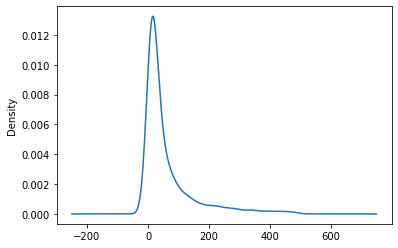

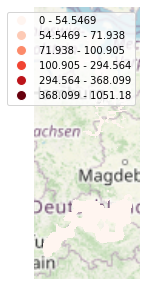

In [10]:
# split multipolygons (total number: 89) into lots of smaller polygon (total number: 3000+)



#split multipolygon to polygon with explode()
dis_multipolygon = explode(eu_kwh_m2)

#convert coordinate reference system
dis_multipolygon = dis_multipolygon.set_crs(crs='EPSG:4326')

#save new capacity map to geojson file
dis_multipolygon.to_file(
    'result/new_energy_density_map.geojson', driver='GeoJSON')



# View distribution of new capacity map

# caculate area of each polygon (km2)
area = dis_multipolygon.to_crs(crs='EPSG:3395').area/1e6


print(area.describe())

# distribution
area[area < 500].plot.kde()

# visualize the biggest polygon
ax = geoplot.webmap(eu, projection=gcrs.WebMercator(),
                    figsize=(5, 5), alpha=0.5)
geoplot.choropleth(
    dis_multipolygon[259:300], hue='val_kwhm2',
    scheme=mapclassify.Quantiles(dis_multipolygon.val_kwhm2, k=6), cmap='Reds',
    legend=True, edgecolor='white', linewidth=0.001, ax=ax
)
plt.show()

# Conclusion:
# the biggest polygon is in center germany
# most polygon smaller than 200km2, Karlsruhe is around 173km2

In [11]:
# rasterize new capacity map
with rasterio.open('original/reference.tif') as dataset:
    kwds = dataset.profile

kwds['width'] = 2000
kwds['height'] = 2000
with rasterio.open('result/new_energy_density_map.tif', mode='w', **kwds) as src:
    # transfrom is very important both in wirte and rasterize
    array = rasterio.features.rasterize(zip(
        eu_kwh_m2.geometry, eu_kwh_m2.val_kwhm2*10000),
        (1000, 1000), transform=kwds['transform'], fill=0)
    src.write_band(1, array)

# Summary
- directly vectorized original denstiy map (kwh/m3): 'result/final.shp'
- Figure 7 information: 'result/storage_potential_eu_kwh.csv'
- new density map (kwh/m2) (split multipolygons into smaller polygons): 'result/new_energy_density_map.geojson'

# maps the energy capacity to the closest point of a set of nodes

In [7]:
# load nodes data from Lisa
nodes = pd.read_csv('example_nodes_45.csv')

# convert lisa's data to GeoDataFrame
capacity_per_node = geopandas.GeoDataFrame(
    nodes, geometry=geopandas.points_from_xy(nodes['x'], nodes['y']))

# init capacity of each node with 0
capacity_per_node['capacity'] = 0

# load new capacity map capacity/area
result = geopandas.read_file('result/new_energy_density_map.geojson')

# calculate salt cave capacity for each polygon and convert from kwh to twh
result['capacity'] = result['val_kwhm2']\
    * result.to_crs(crs='EPSG:3395').area*1e-9
# unit twh
result

val_kwhm2                                           geometry   capacity
0      47.958683  POLYGON ((19.97965 40.96842, 20.00255 40.96842...   0.411418
1      71.938024  POLYGON ((20.36909 39.78483, 20.36909 39.80007...   0.153194
2      71.938024  POLYGON ((20.39200 39.81141, 20.39200 39.82446...   0.037924
3      71.938024  POLYGON ((20.18582 39.63971, 20.18663 39.63971...   0.000399
4      71.938024  POLYGON ((19.79638 40.85387, 19.81928 40.85387...   0.616051
...          ...                                                ...        ...
3878  140.672107  POLYGON ((24.37812 46.74142, 24.46976 46.74142...  13.300370
3879  140.672107  POLYGON ((24.28649 46.14579, 24.30940 46.14579...  32.856128
3880  140.672107  POLYGON ((24.14904 46.28324, 24.17195 46.28324...   2.637957
3881  140.672107  POLYGON ((24.17195 46.28324, 24.17195 46.32906...   6.600723
3882  140.672107  POLYGON ((23.96577 46.55815, 23.98868 46.55815...  17.224601

[3883 rows x 3 columns]

In [153]:
def assgin_capacity2node(nodes,country_path,offshore_path,capacity_path,considered_locations=['onshore','nearshore','offshore']):
    capacity_df=gpd.read_file(capacity_path)
    onshore=gpd.read_file(country_path)
    offshore=gpd.read_file(offshore_path)
    nodes=nodes.set_crs('EPSG:4326')
    lines=[]
    
    rest_result= capacity_df[capacity_df['storage_type'].isin(considered_locations)]
    
    full_table=[]
    for country in tqdm(onshore['name']):
        try:
            mask=geopandas.GeoDataFrame(pd.concat([onshore[onshore['name'] == country],
                                                   offshore[offshore['name']==country]],ignore_index=True))
            mask=mask.set_crs('EPSG:4326')
        except:
            mask=onshore[onshore['name'] == country]

        part_result=geopandas.clip(rest_result,mask)
        #
        rest_result=rest_result[~rest_result.index.isin(part_result.index)]
        part_result=part_result.reset_index()
        part_nodes=geopandas.clip(nodes,mask).reset_index()

        for i in range(len(part_result)):
            inx = part_nodes.geometry.apply(lambda x: x.distance(part_result.loc[i,'geometry']))\
                  .argmin()
            part_nodes.loc[inx,'capacity']+=part_result.loc[i,'capacity']
            lines.append(LineString([part_nodes.loc[inx,'geometry'],part_result.loc[i,'geometry'].centroid]))
        full_table.append(part_nodes)

        #verify total capacity
    capacity_per_node=geopandas.GeoDataFrame(pd.concat(full_table,ignore_index=True))
    capacity_per_node=capacity_per_node.set_crs('EPSG:4326')
    
    return capacity_per_node

In [154]:
nodes = pd.read_csv('example_nodes_45.csv')

# convert lisa's data to GeoDataFrame
capacity_per_node = geopandas.GeoDataFrame(
    nodes, geometry=geopandas.points_from_xy(nodes['x'], nodes['y']))

# init capacity of each node with 0
capacity_per_node['capacity'] = 0
df=assgin_capacity2node(capacity_per_node,'resources/country_shapes.geojson','resources/offshore_shapes.geojson','result/new_energy_capacity_map_pwh.geojson')

  6%|▌         | 2/33 [00:00<00:02, 14.94it/s]

88.01878753133951


100%|██████████| 33/33 [00:03<00:00,  9.70it/s]


In [155]:
df.capacity.sum()

88.0187875313395

100%|██████████| 33/33 [00:14<00:00,  2.31it/s]


87.97956134501015


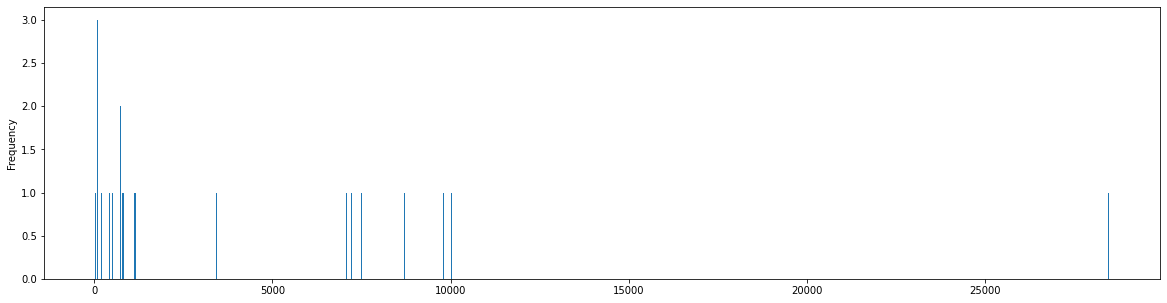

In [43]:
#maps the energy capacity to the closest point of a set of nodes
#lines is used to record mapping relationships between polygons and nodes
lines=[]

onshore = geopandas.read_file('onshore_shapes/country_shapes.geojson')
offshore = geopandas.read_file('onshore_shapes/offshore_shapes.geojson')

#select result from geojson

rest_result=result.copy()

full_table=[]
for country in tqdm(onshore['name']):
    try:
        mask=geopandas.GeoDataFrame(pd.concat([onshore[onshore['name'] == country],
                                               offshore[offshore['name']==country]],ignore_index=True))
    except:
        mask=onshore[onshore['name'] == country]
        
    part_result=geopandas.clip(rest_result,mask)
    #
    rest_result=rest_result[~rest_result.index.isin(part_result.index)]
    part_result=part_result.reset_index()
    part_nodes=geopandas.clip(nodes,mask).reset_index()
    
    for i in range(len(part_result)):
        inx = part_nodes.geometry.apply(lambda x: x.distance(part_result.loc[i,'geometry']))\
              .argmin()
        part_nodes.loc[inx,'capacity']+=part_result.loc[i,'capacity']
        lines.append(LineString([part_nodes.loc[inx,'geometry'],part_result.loc[i,'geometry'].centroid]))
    full_table.append(part_nodes)

    #verify total capacity
capacity_per_node=geopandas.GeoDataFrame(pd.concat(full_table,ignore_index=True))
capacity_per_node=capacity_per_node.set_crs('EPSG:4326')
print(capacity_per_node.capacity.sum()*1e-3)
#twh

# histgram of node capacity 
capacity_per_node[capacity_per_node.capacity>0].capacity.plot.hist(bins=1000, figsize=(20,5))
plt.show()

<GeoAxesSubplot:>

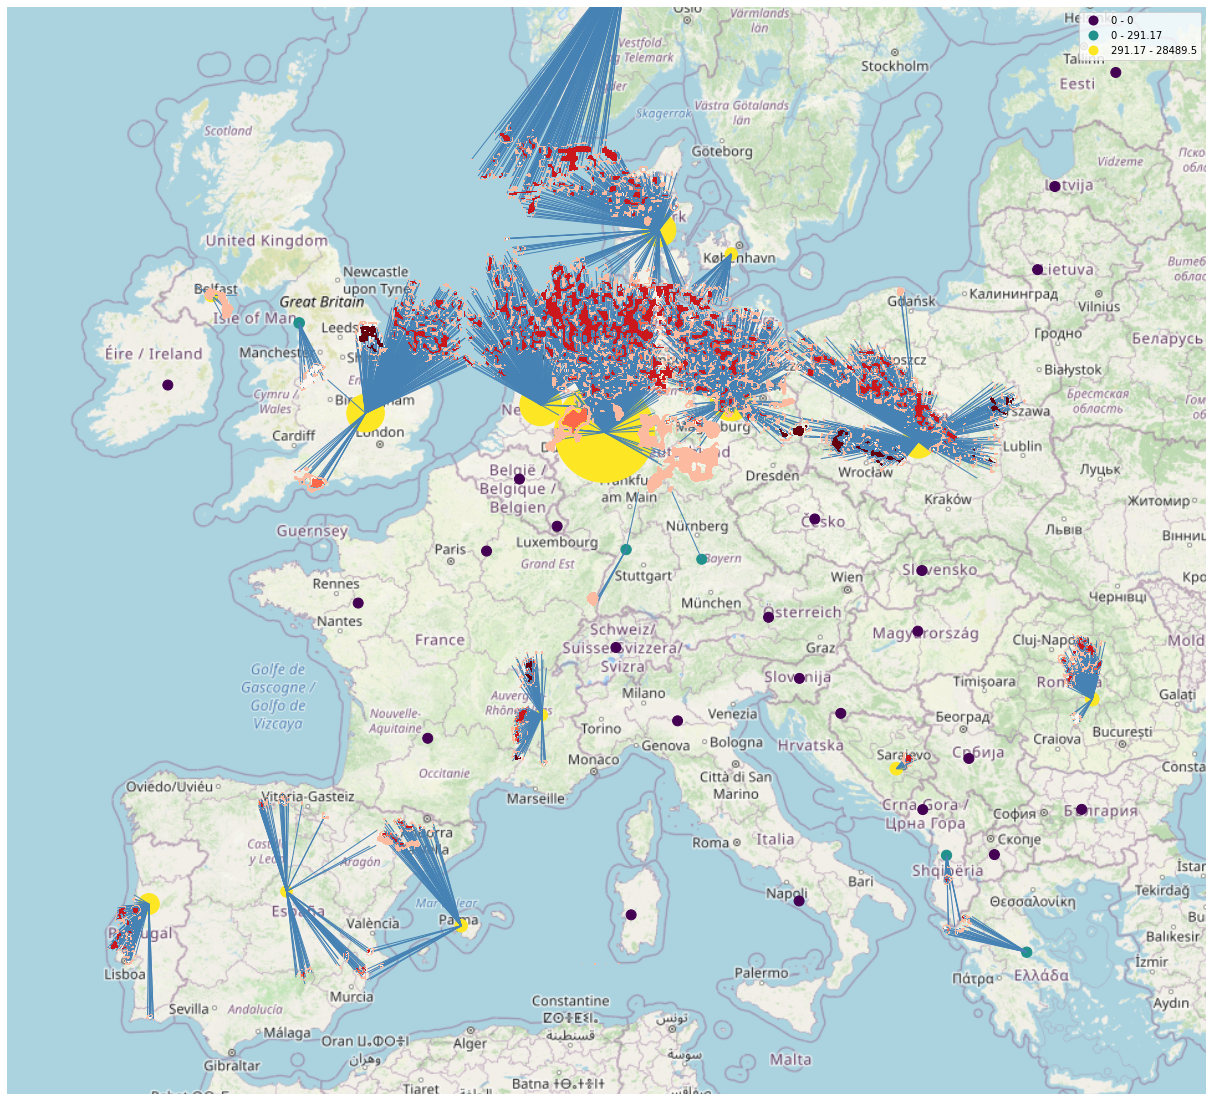

In [42]:
eu=geopandas.read_file('eu_shapes/country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=0.5)

scheme1 = mapclassify.Quantiles(capacity_per_node.capacity, k=3)

#plot mapping relationship
geoplot.sankey(geopandas.GeoDataFrame(geometry=lines),ax=ax)

#plot nodes
geoplot.pointplot(
    capacity_per_node , projection=gcrs.AlbersEqualArea(),
    scale='capacity', limits=(10, 100),
    hue='capacity', cmap='viridis', scheme=scheme1,
    legend=True, legend_var='hue',
    ax=ax
)

#plot energy density map
value = geodataframe['val_kwhm3']
scheme = mapclassify.Quantiles(value, k=5)
geoplot.choropleth(
   geodataframe, hue=value,scheme=scheme,cmap='Reds',
    legend=False,edgecolor='white',linewidth=0.001,ax=ax
)



In [15]:
#why i choose different package to finish this task
#choose twh or pwh 
#make a summary slide
#capacity per polygon map (not per surface!!)

make the notebook beautiful and clear
code style

pep8
doc string
no abbreivation
pypsa

Tues 11

In [ ]:
new problem of shapefile:
    
there is overlap in country_shape or offshore_shape

In [45]:
geopandas.overlay(eu[eu['name']=='DE'],eu)

name_1 name_2                                           geometry
0     DE     CH  MULTIPOLYGON (((9.54748 47.53455, 9.43843 47.5...
1     DE     CZ  MULTIPOLYGON (((14.74833 50.81282, 14.73753 50...
2     DE     DE  MULTIPOLYGON (((8.90414 54.89794, 9.19477 54.8...
3     DE     LU  MULTIPOLYGON (((6.50258 49.79567, 6.39706 49.8...
4     DE     PL  MULTIPOLYGON (((15.02206 51.23677, 15.02206 51...

In [3]:
eu = geopandas.read_file('eu_shapes/country_shapes.geojson')
costa=geopandas.read_file('eu_shapes/offshore_shapes.geojson')
find_overlap=geopandas.GeoDataFrame(pd.concat([eu,costa],ignore_index=True)).set_crs('EPSG:4326')


In [4]:
find_overlap=eu

In [5]:
def geo_concat(list_to_concat):
    return geopandas.GeoDataFrame(pd.concat(list_to_concat,ignore_index=True)).set_crs('EPSG:4326')

In [6]:
overlap=[]
for country in find_overlap['name']:
    rest=find_overlap[~find_overlap.index.isin(find_overlap[find_overlap['name']==country].index)]
    overlap.append(geopandas.overlay(find_overlap[find_overlap['name']==country],rest))
                   
overlap=geo_concat(overlap)

In [7]:
overlap['capacity']=1000

<GeoAxesSubplot:>

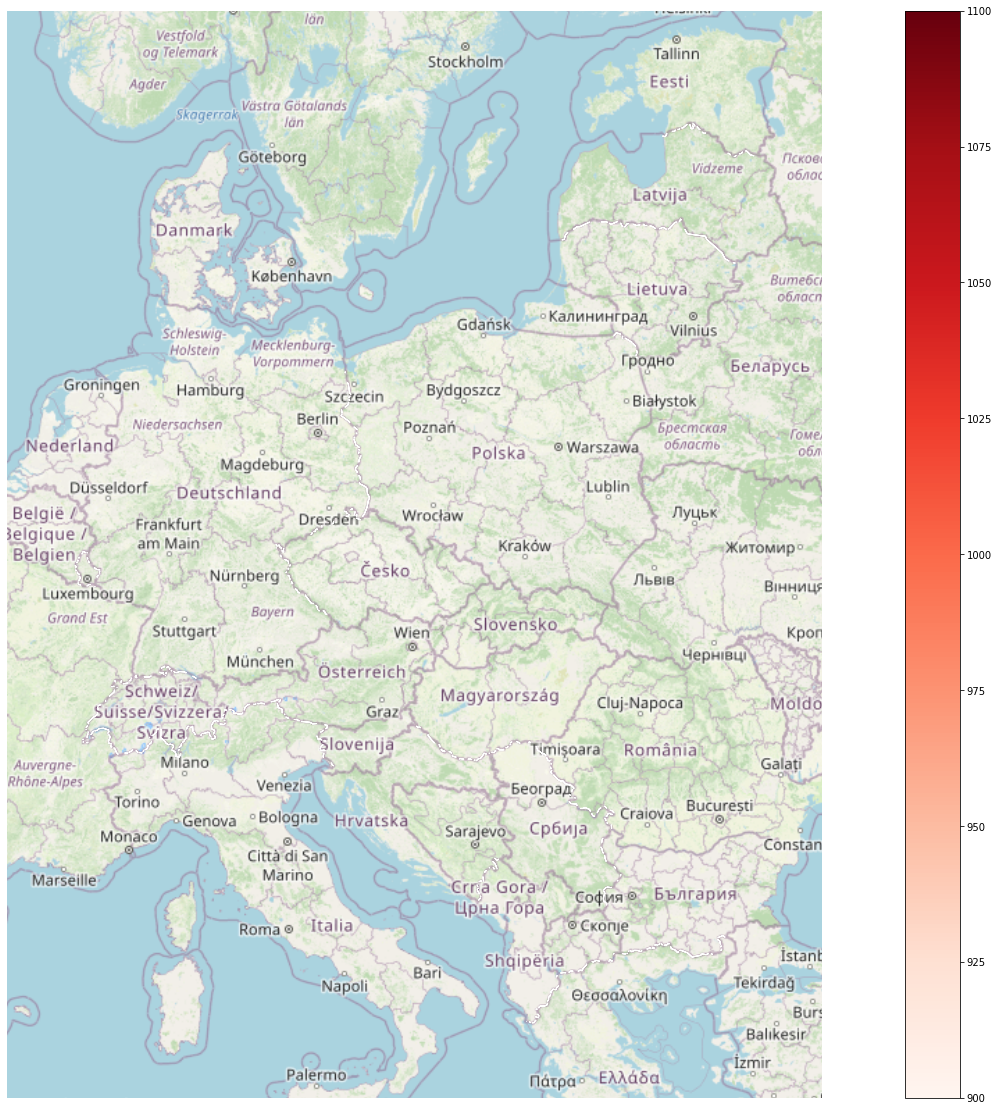

In [11]:
eu=geopandas.read_file('eu_shapes/country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=0.5)
geoplot.choropleth(
   overlap,cmap='Reds',hue='capacity',
    legend=True,edgecolor='white',ax=ax
)